#  Preparing the data 

### Importing the required libraries

In [4]:
from ultralytics import YOLO
from imageai.Detection import ObjectDetection
import os 
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
import tensorflow.image as tfi
import random
import cv2
from PIL import Image
import sklearn
import seaborn as sbe

### loading the dataset

In [5]:
import tifffile as tiff
# Path to the directory containing TIFF files
directory = "data/images"
input_data_images=[]
# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        file_path = os.path.join(directory, filename)

        # Load the TIFF file using tifffile
        try:
            input_data_images.append (np.array(tiff.imread(file_path))) 
        except Exception as e:
            print(f"Failed to load {filename}: {e}")


In [6]:
import glob  # To find files matching a pattern
import os    # For file path operations and deleting files
from PIL import Image  # To open and process images
import numpy as np  # To convert images to NumPy arrays
import re
# Path to the directory containing images
directory = "data/labels"
segmentation_labels = []
## this is used for the numerical ordering in the files name not by the string ordering 
def natural_key(file_name):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', file_name)]

image_files = sorted(glob.glob(os.path.join(directory, '*.[pjJ][npN]*[gG]*')), key=natural_key)
# Load and process each image
for file_path in image_files:
    try:
        # Check if the filename contains an underscore
        if "_" in os.path.basename(file_path):
            os.remove(file_path)  # Remove the file if it contains an underscore    
        else:
            # Open the image, convert to NumPy array, and append to the list
            image = Image.open(file_path)
            segmentation_labels.append(np.array(image))
            print(file_path)
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")



data/labels\0.png
data/labels\1.png
data/labels\2.png
data/labels\3.png
data/labels\4.png
data/labels\5.png
data/labels\6.png
data/labels\7.png
data/labels\8.png
data/labels\9.png
data/labels\10.png
data/labels\11.png
data/labels\12.png
data/labels\13.png
data/labels\14.png
data/labels\15.png
data/labels\16.png
data/labels\17.png
data/labels\18.png
data/labels\19.png
data/labels\20.png
data/labels\21.png
data/labels\22.png
data/labels\23.png
data/labels\24.png
data/labels\25.png
data/labels\26.png
data/labels\27.png
data/labels\28.png
data/labels\29.png
data/labels\30.png
data/labels\31.png
data/labels\32.png
data/labels\33.png
data/labels\34.png
data/labels\35.png
data/labels\36.png
data/labels\37.png
data/labels\38.png
data/labels\39.png
data/labels\40.png
data/labels\41.png
data/labels\42.png
data/labels\43.png
data/labels\44.png
data/labels\45.png
data/labels\46.png
data/labels\47.png
data/labels\48.png
data/labels\49.png
data/labels\50.png
data/labels\51.png
data/labels\52.png
dat

In [7]:
for i in segmentation_labels[:5]:
    print(i.shape)
for i in input_data_images[:1]:
    print(i)
print(len(segmentation_labels))
print(np.array(segmentation_labels).shape)
print(np.array(input_data_images).shape)
print(len(input_data_images))

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
[[[131  48  73 ... 316  80   0]
  [142  41  74 ... 316  80   0]
  [142  50  88 ... 317  30   0]
  ...
  [276 234 451 ... 256  10   0]
  [276 241 479 ... 250  10   0]
  [269 230 416 ... 247  10   0]]

 [[173 115 243 ... 320  80   0]
  [153 105 214 ... 321  80   0]
  [153 116 215 ... 323  10   0]
  ...
  [332 307 504 ... 247  10   0]
  [332 271 503 ... 242  10   0]
  [308 249 453 ... 239  10   0]]

 [[173 134 295 ... 326  10   0]
  [153 165 321 ... 326  10   0]
  [153 191 342 ... 328  10   0]
  ...
  [332 384 565 ... 232  10   0]
  [332 371 528 ... 228  10   0]
  [308 336 537 ... 226  10   0]]

 ...

 [[113 108 275 ... 367  10   0]
  [117  86 239 ... 370  10   0]
  [117  82 232 ... 374  10   0]
  ...
  [239 395 587 ... 240  10   0]
  [239 231 418 ... 237  10   0]
  [179 152 333 ... 234  10   0]]

 [[113 114 266 ... 368  10   0]
  [117 120 283 ... 371  10   0]
  [117 107 266 ... 375  10   0]
  ...
  [239 240 409 ... 230  10   0]
  [23

#### Scaling the input data 

we had to normalize the data in order to have the best accuracy in our model as we will classify each pixel as to be watery or un_watery pixel this will result in higher accuracy and we use sklearn lib to help us having the min and max in the data set and normalize based on this 

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaled_input_data_images=[]
for image_array in input_data_images:
    
    # Reshape the array to 2D (pixels x channels)
    original_shape = image_array.shape
    reshaped_array = image_array.reshape(-1, original_shape[-1])

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the data
    scaled_array = scaler.fit_transform(reshaped_array)

    # Reshape back to the original dimensions
    scaled_input_data_images.append(scaled_array.reshape(original_shape)) 


print(len(scaled_input_data_images))



306


### Dividing the data set into training,testing and validation 

here we should divide our dataset into train ,test and validation in order to have some images to test the model that we have created and some of the 
data to validate the model that we have created this teq will help in the model testing and validation 


In [9]:
#len(input_data_images) # this is the len of the training dataset
# so now we need to divide them into training , testing and validation data
def dividing_data(ds,val_size=0.1,test_size=0.1,train_size=0.8):
    train_len=int(len(ds)*train_size)
    test_len=int(len(ds)*test_size)
    val_len=int(len(ds)*val_size)
    train_data=ds[:train_len]
    test_data=ds[train_len:(test_len+train_len)]
    val_data=ds[(test_len+train_len):len(ds)]
    return train_data,test_data,val_data
train_input_data_images,test_input_data_images,val_input_data_images=dividing_data(scaled_input_data_images)
train_segmentation_labels,test_segmentation_labels,val_segmentation_labels=dividing_data(segmentation_labels)


## Preparing the model :)

U-Net
The U-Net architecture was initially designed for medical image segmentation, but it has since been adapted for many other use cases.

this architecture is used for classification of each pixel to be watery or un_watery so the result of this model will be 0 or 1 (to be binary classification) 

this is what we call image segmentation and it is similar to object detection except in object detection we make groups of window for the object in the image and classify them 



In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
## we will use the functional teq of deep learning 
# Image_Width=128
# Image_height=128
# Channels=12
# ## this is the encoding step 
# ## the first step
# inputs=tf.keras.layers.Input((Image_Width,Image_height,Channels)) # the input layer 
# c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(inputs)
# c1=tf.keras.layers.Dropout(0.1)(c1)
# c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(c1)
# p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
# # the second step
# c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(p1)
# c2=tf.keras.layers.Dropout(0.1)(c2)
# c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(c2)
# p2=tf.keras.layers.MaxPooling2D((2,2))(c2)
# #the third step
# c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(p2)
# c3=tf.keras.layers.Dropout(0.1)(c3)
# c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(c3)
# p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
# #the fourth step
# c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(p3)
# c4=tf.keras.layers.Dropout(0.1)(c4)
# c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(c4)
# p4=tf.keras.layers.MaxPooling2D((2,2))(c4)
# ## the fifth step
# c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(p4)
# c5=tf.keras.layers.Dropout(0.1)(c5)
# c5=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(c5)
# ## the decoding step
# #the first step 
# u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = tf.keras.layers.concatenate([u6, c4])
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
# c6=tf.keras.layers.Dropout(0.1)(c6)
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
# #the second step
# u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = tf.keras.layers.concatenate([u7, c3])
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
# c7=tf.keras.layers.Dropout(0.1)(c7)
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
# #the third step 
# u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = tf.keras.layers.concatenate([u8, c2])
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
# c8=tf.keras.layers.Dropout(0.1)(c8)
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
# ## the fourth step
# u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c1])
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
# c9=tf.keras.layers.Dropout(0.1)(c9)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
# ##then we have the output layer 
# outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)
# ##creating the model
# unet_model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
# unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print the model summary
# unet_model.summary()

# Assuming input image shape is (128, 128, 12)
Image_Width = 128
Image_height = 128
Channels = 12

# Input layer
inputs = tf.keras.layers.Input((Image_Width, Image_height, Channels))

# Encoding path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# Bottleneck
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

# Decoding path with Conv2DTranspose for upsampling
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

# Output layer with shape (128, 128, 1)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Create model
unet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compile the model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 1,581,825 (6.03 MB)

 Trainable params: 1,581,825 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
train_input_data_images=np.array(train_input_data_images)
train_segmentation_labels=np.array( train_segmentation_labels)
val_input_data_images=np.array(val_input_data_images)
val_segmentation_labels=np.array(val_segmentation_labels)
history = unet_model.fit(train_input_data_images, train_segmentation_labels, validation_data=(val_input_data_images, val_segmentation_labels), epochs=50)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 657ms/step - accuracy: 0.6951 - loss: 0.6556 - val_accuracy: 0.6964 - val_loss: 0.6004
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.7731 - loss: 0.5577 - val_accuracy: 0.6964 - val_loss: 0.6057
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.7467 - loss: 0.5868 - val_accuracy: 0.6964 - val_loss: 0.6018
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.7536 - loss: 0.5724 - val_accuracy: 0.6964 - val_loss: 0.6015
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.7361 - loss: 0.5883 - val_accuracy: 0.6964 - val_loss: 0.6045
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - accuracy: 0.7581 - loss: 0.5673 - val_accuracy: 0.6964 - val_loss: 0.6096
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.7524 - loss: 0.5679 - val_accuracy: 0.6964 - val_loss: 0.6106
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.7333 - loss: 0.5856 - val_accuracy: 0.6964 - val_loss

In [12]:
test_segmentation_labels=np.array(test_segmentation_labels)
test_input_data_images=np.array(test_input_data_images)
unet_model.evaluate(test_input_data_images,test_segmentation_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.7373 - loss: 0.6468


[0.6468374729156494, 0.7373392581939697]

### displaying the results 

In [13]:
predictions=unet_model.predict(test_input_data_images)
print(predictions.shape)
print(test_segmentation_labels[:2])
print("################")
print(predictions[:2])
print(test_segmentation_labels.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
(30, 128, 128, 1)
[[[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]]
################
[[[[    0.28996]
   [    0.24276]
   [    0.21792]
   ...
   [    0.20889]
   [    0.22431]
   [    0.27019]]

  [[    0.19967]
   [    0.17771]
   [    0.17831]
   ...
   [    0.16788]
   [     0.1928]
   [    0.23516]]

  [[    0.18538]
   [     0.1634]
   [     0.1645]
   ...
   [    0.15715]
   [    0.18542]
   [    0.23221]]

  ...

  [[    0.16294]
   [    0.12387]
   [    0.11588]
   ...
   [    0.12028]
   [    0.11328]
   [    0.15557]]

  [[     0.1699]
   [    0.11291]
   [    0.11964]
   ...
   [   0.093234]
   [    0.10422]
   [    0.15253]]

  [[    0.19672]
   [    0.14234]
   [    0.14009]
   ...
   [    0.11029]
   [     0.1275]
   [      0.183]

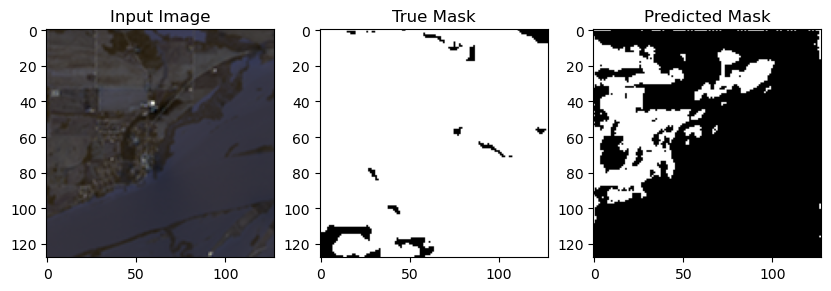

In [23]:
# Apply threshold of 0.5 to convert probabilities into binary values (0 or 1)
binary_predictions = (predictions >= 0.2).astype(np.uint8)
# Example function to display results
def display_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image[:, :, :3])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    
    

# Display the first test sample and its prediction
display_prediction(test_input_data_images[0], test_segmentation_labels[0], binary_predictions[0])

## Visualizations 

In [24]:
from sklearn.metrics import classification_report
# Flatten arrays for confusion matrix computation
y_true_flat = test_segmentation_labels.flatten()
y_pred_flat = binary_predictions.flatten()
print(classification_report(y_true_flat,y_pred_flat))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70    362417
           1       0.21      0.24      0.23    129103

    accuracy                           0.57    491520
   macro avg       0.47      0.46      0.46    491520
weighted avg       0.58      0.57      0.57    491520

